框架

    一、导入数据
    二、原始序列的检验
    三、一阶差分序列的检验
    四、定阶（参数调优)
    五、建模与预测
    
    参考材料：《Python数据分析与挖掘实践》

### 工具准备

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Simhei']
# 解决坐标轴刻度负号乱码
plt.rcParams['axes.unicode_minus'] = False

#pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  #自相关图、偏自相关图
from statsmodels.tsa.stattools import adfuller as ADF #平稳性检验
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
import statsmodels.api as sm #D-W检验,一阶自相关检验
from statsmodels.graphics.api import qqplot #画QQ图,检验一组数据是否服从正态分布
from statsmodels.tsa.arima_model import ARIMA

### 一、导入数据

In [2]:
sale=pd.read_excel('./arima_data.xls',index_col='日期')
sale.head()

,销量
日期,
2015-01-01,3023
2015-01-02,3039
2015-01-03,3056
2015-01-04,3138
2015-01-05,3188


In [3]:
sale.tail()

,销量
日期,
2015-02-02,4493
2015-02-03,4560
2015-02-04,4637
2015-02-05,4755
2015-02-06,4817


In [4]:
sale.info()
print('-----')
sale.销量=sale.销量.astype('float')
sale.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2015-01-01 to 2015-02-06
Data columns (total 1 columns):
销量    37 non-null int64
dtypes: int64(1)
memory usage: 592.0 bytes
-----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2015-01-01 to 2015-02-06
Data columns (total 1 columns):
销量    37 non-null float64
dtypes: float64(1)
memory usage: 592.0 bytes


### 二、原始序列的检验

- 时序图

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

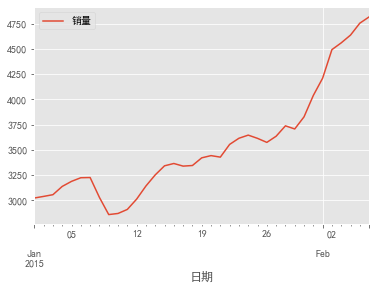

In [5]:
plt.figure(figsize=(10,5))
sale.plot()
plt.show()

#解读：具有单调递增趋势，则是非平稳序列。

- 自相关图

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.


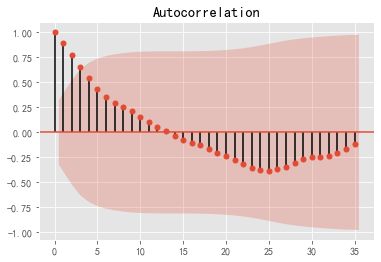

In [6]:
plot_acf(sale,lags=35).show()

#解读：自相关系数长期大于零，没有趋向于零，说明序列间具有很强的长期相关性。

- 平稳性检验

In [7]:
#方法：单位根检验

print('原始序列的ADF检验结果为：',ADF(sale.销量))

#解读：P值大于显著性水平α（0.05），接受原假设（非平稳序列），说明原始序列是非平稳序列。

原始序列的ADF检验结果为： (1.813771015094526, 0.9983759421514264, 10, 26, {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}, 299.4698986602418)


第一个是adf检验的结果。
第二个是统计量的P值。
第三个是计算过程中用到的延迟阶数。
第四个是用于ADF回归和计算的观测值的个数。
第五个是配合第一个一起看的，是在99%，95%，90%置信区间下的临界的ADF检验的值。

原文链接：https://blog.csdn.net/qq_36707798/article/details/88640684

### 三、一阶差分序列的检验

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

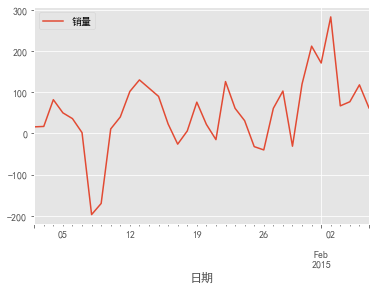

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


原始序列的ADF检验结果为： (-3.1560562366723537, 0.022673435440048798, 0, 35, {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}, 287.5909090780334)


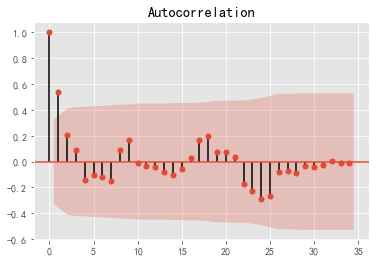

In [8]:
d1_sale=sale.diff(periods=1, axis=0).dropna()

#时序图
plt.figure(figsize=(10,5))
d1_sale.plot()
plt.show()
#解读：在均值附件比较平稳波动

#自相关图
plot_acf(d1_sale,lags=34).show()
#解读：有短期相关性，但趋向于零。

#平稳性检验
print('原始序列的ADF检验结果为：',ADF(d1_sale.销量))

#解读：P值小于显著性水平α（0.05），拒绝原假设（非平稳序列），说明一阶差分序列是平稳序列。

- 白噪声检验

In [9]:
print('一阶差分序列的白噪声检验结果为：',acorr_ljungbox(d1_sale,lags=1))#返回统计量、P值

#解读：p值小于0.05，拒绝原假设（纯随机序列），说明一阶差分序列是非白噪声。

一阶差分序列的白噪声检验结果为： (array([11.30402222]), array([0.00077339]))


### 四、定阶

- 参数调优：人工识图

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


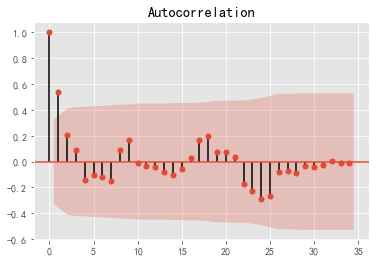

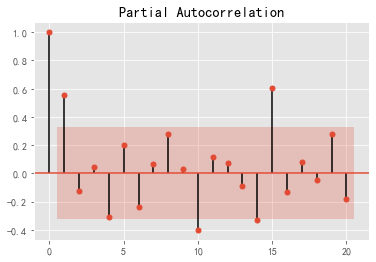

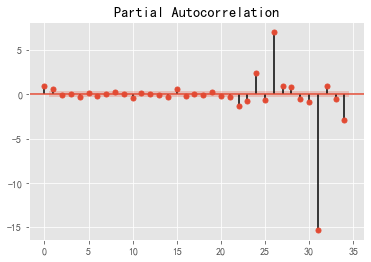

In [10]:
d1_sale=sale.diff(periods=1, axis=0).dropna()

#自相关图
plot_acf(d1_sale,lags=34).show()

#解读：有短期相关性，但趋向于零。

#偏自相关图
plot_pacf(d1_sale,lags=20).show()


#偏自相关图
plot_pacf(d1_sale,lags=34).show()

#解读：自相关图，1阶截尾；偏自相关图，拖尾。则ARIMA(p,d,q)=ARIMA(0,1,1)

- 参数调优：BIC

    模型调优的方法：AIC和BIC
    值越小越好
    参数调优的方法非常多，用不同方法得出的结论可能不同

In [11]:
pmax=int(len(d1_sale)/10) #一般阶数不超过length/10
qmax=int(len(d1_sale)/10) #一般阶数不超过length/10
pmax
qmax

3

3

In [12]:
bic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(sale,(p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [13]:
bic_matrix=pd.DataFrame(bic_matrix)
bic_matrix

,0,1,2,3
0,432.068472,422.510082,426.088911,426.595507
1,423.628276,426.073601,NaN,NaN
2,426.774824,427.395856,NaN,NaN
3,430.317524,431.924894,434.761700,436.478109


In [14]:
bic_matrix.stack()

0  0    432.068472
   1    422.510082
   2    426.088911
   3    426.595507
1  0    423.628276
   1    426.073601
2  0    426.774824
   1    427.395856
3  0    430.317524
   1    431.924894
   2    434.761700
   3    436.478109
dtype: float64

In [64]:
p,q=bic_matrix.stack().idxmin() #最小值的索引
print('用BIC方法得到最优的p值是%d,q值是%d'%(p,q))

用BIC方法得到最优的p值是0,q值是1


- 参数调优：AIC

In [15]:
pmax=int(len(d1_sale)/10) #一般阶数不超过length/10
qmax=int(len(d1_sale)/10) #一般阶数不超过length/10

aic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(sale,(p,1,q)).fit().aic)
        except:
            tmp.append(None)
    aic_matrix.append(tmp)
aic_matrix=pd.DataFrame(aic_matrix)
p,q=aic_matrix.stack().idxmin() #最小值的索引

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\

In [16]:
print('用AIC方法得到最优的p值是%d,q值是%d'%(p,q))

用AIC方法得到最优的p值是0,q值是1


### 五、建模及预测

#### （1）建模

In [17]:
#创建模型
model=ARIMA(sale,(0,1,1)).fit()
#查看模型报告
model.summary2()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 422.5101  
Dependent Variable: D.销量             Log-Likelihood:      -205.88   
Date:               2020-06-29 09:12 Scale:               1.0000    
No. Observations:   36               Method:              css-mle   
Df Model:           2                Sample:              01-02-2015
Df Residuals:       34                                    02-06-2015
Converged:          1.0000           S.D. of innovations: 73.086    
No. Iterations:     15.0000          HQIC:                419.418   
AIC:                417.7595                                        
----------------------------------------------------------------------
               Coef.    Std.Err.     t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const         49.9564    20.1390   2.4806   0.0182   10.4847   89.4281
ma.L1.D.销量     0.6710     0.1648   4.0712   0.0003    0.3480    0.9941
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
MA.1           -1.4902             0.0000           1.4902             0.5000
====================================================================

"""

#### （2）残差检验

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


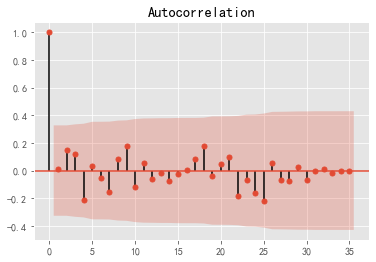

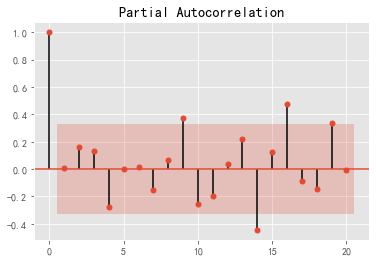

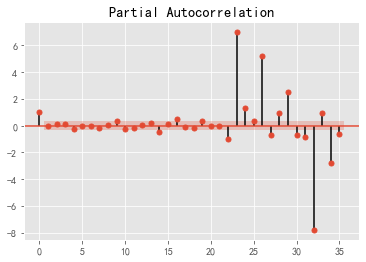

In [18]:
resid=model.resid

#自相关图
plot_acf(resid,lags=35).show()

#解读：有短期相关性，但趋向于零。

#偏自相关图
plot_pacf(resid,lags=20).show()

#偏自相关图
plot_pacf(resid,lags=35).show()

- QQ图

线性即正态分布

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.


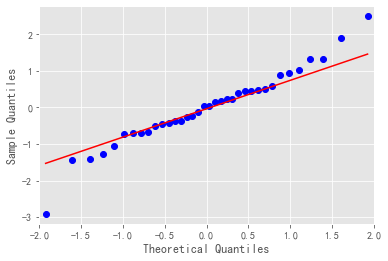

In [89]:
qqplot(resid, line='q', fit=True).show() 

#解读：残差服从正态分布，均值为零，方差为常数

- D-W检验

 德宾-沃森检验,简称D-W检验，是目前检验自相关性最常用的方法，但它只适用于检验一阶自相关性。
    因为自相关系数ρ的值介于-1和1之间，所以 0≤DW≤４。
- 并且DW＝O ＜ ＝＞ ρ＝１　　即存在正自相关性
- DW＝４   ＜＝＞  ρ＝－１　即存在负自相关性
- DW＝２   ＜＝＞  ρ＝０　　即不存在（一阶）自相关性

因此，当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。

原文链接：https://blog.csdn.net/u010414589/article/details/49622625

In [19]:
print('D-W检验的结果为：',sm.stats.durbin_watson(resid.values))  

#解读：不存在一阶自相关

D-W检验的结果为： 1.9734861502397292


- Ljung-Box检验

Ljung-Box test是对randomness的检验,或者说是对时间序列是否存在滞后相关的一种统计检验。对于滞后相关的检验，我们常常采用的方法还包括计算ACF和PCAF并观察其图像，但是无论是ACF还是PACF都仅仅考虑是否存在某一特定滞后阶数的相关。LB检验则是基于一系列滞后阶数，判断序列总体的相关性或者说随机性是否存在。
时间序列中一个最基本的模型就是高斯白噪声序列。而对于ARIMA模型，其残差被假定为高斯白噪声序列，所以当我们用ARIMA模型去拟合数据时，拟合后我们要对残差的估计序列进行LB检验，判断其是否是高斯白噪声，如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。

检验的结果就是看最后一列前十二行的检验概率（一般观察滞后1~12阶），如果检验概率小于给定的显著性水平，比如0.05、0.10等就拒绝原假设，其原假设是相关系数为零。

原文链接：https://blog.csdn.net/u010414589/article/details/49622625

In [20]:
# 方法一
print('残差序列的白噪声检验结果为：',acorr_ljungbox(resid,lags=1))#返回统计量、P值

#解读：残差是白噪声

残差序列的白噪声检验结果为： (array([0.00390451]), array([0.95017574]))


In [21]:
# 方法二
confint,qstat,pvalues = sm.tsa.acf(resid.values, qstat=True) #qstat is Ljung-Box Q-Statistic. confint is  Confidence intervals for the ACF
data = np.c_[range(1,36), confint[1:], qstat, pvalues]
table = pd.DataFrame(data, columns=['lag', "confint", "qstat", "pvalues(>Q)"])
print(table.set_index('lag'))

       confint      qstat  pvalues(>Q)
lag                                   
1.0   0.009995   0.003905     0.950176
2.0   0.151097   0.922486     0.630500
3.0   0.119393   1.513403     0.679180
4.0  -0.212564   3.445001     0.486290
5.0   0.034075   3.496238     0.623957
6.0  -0.053348   3.626018     0.727135
7.0  -0.157088   4.790082     0.685563
8.0   0.082868   5.125587     0.744073
9.0   0.180436   6.775151     0.660516
10.0 -0.119683   7.528820     0.674754
11.0  0.051306   7.672861     0.742274
12.0 -0.062678   7.896789     0.793143
13.0 -0.020659   7.922174     0.848633
14.0 -0.078650   8.306819     0.872737
15.0 -0.024755   8.346738     0.909130
16.0  0.001821   8.346965     0.937860
17.0  0.081164   8.821273     0.945702
18.0  0.181184  11.316172     0.880461
19.0 -0.036607  11.424008     0.908751
20.0  0.049095  11.630087     0.928220
21.0  0.095998  12.470555     0.926035
22.0 -0.186408  15.865932     0.822483
23.0 -0.066136  16.326204     0.840953
24.0 -0.160985  19.280654

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


【补充说明】

    如果残差不是白噪声，可以考虑取另外一组p、q值；或者该数据不适应ARIMA模型。

#### （3）预测

In [67]:
#预测
print('未来7天的销量预测：')
model.forecast(7) #预测、标准差、置信区间

未来7天的销量预测：


(array([4873.9667493 , 4923.92317644, 4973.87960359, 5023.83603073,
        5073.79245787, 5123.74888501, 5173.70531215]),
 array([ 73.08574293, 142.32679918, 187.542821  , 223.80281869,
        254.95704265, 282.69857718, 307.95109593]),
 array([[4730.72132537, 5017.21217324],
        [4644.96777602, 5202.87857687],
        [4606.30242887, 5341.4567783 ],
        [4585.19056646, 5462.48149499],
        [4574.08583666, 5573.49907907],
        [4569.66985525, 5677.82791477],
        [4570.13225512, 5777.27836918]]))

In [22]:
forecast=pd.Series(model.forecast(7)[0],index=pd.date_range('2015-2-7',periods=7,freq='D'))
forecast

2015-02-07    4873.966749
2015-02-08    4923.923176
2015-02-09    4973.879604
2015-02-10    5023.836031
2015-02-11    5073.792458
2015-02-12    5123.748885
2015-02-13    5173.705312
Freq: D, dtype: float64

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

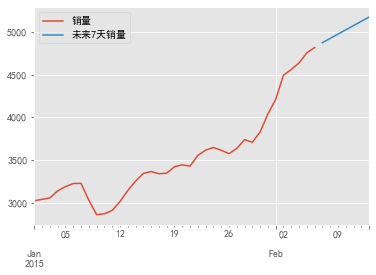

In [23]:
data=pd.concat((sale,forecast),axis=0)
data.columns=['销量','未来7天销量']
plt.figure(figsize=(10,5))
data.plot()
plt.show()